**1. Import dependencies**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras.preprocessing.image as Image
import cv2
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
from tf_bodypix.draw import draw_pose  # utility function using OpenCV
from pathlib import Path

2024-05-06 19:03:31.456461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2. Init Constant**

In [2]:
body_parts = {
  'left_arm': ['left_upper_arm_front', 'left_upper_arm_back', 'left_lower_arm_front', 'left_lower_arm_back'],
  'right_arm': ['right_upper_arm_front', 'right_upper_arm_back', 'right_lower_arm_front', 'right_lower_arm_back'],
  'torso': ['torso_front', 'torso_back'],
  'left_leg': ['left_upper_leg_front', 'left_upper_leg_back', 'left_lower_leg_front', 'left_lower_leg_back'],
  'right_leg': ['right_upper_leg_front', 'right_upper_leg_back', 'right_lower_leg_front', 'right_lower_leg_back']
}

In [3]:
skeleton_parts = {
  'head': ['leftEar', 'rightEar'],
  'left_arm': ['leftShoulder', 'leftElbow'],
  'right_arm': ['rightShoulder', 'rightElbow'],
  'torso': {
      'shoulder': ['leftShoulder', 'rightShoulder'],
      'hip': ['leftHip', 'rightHip']
  },
  'left_leg': ['leftHip', 'leftKnee'],
  'right_leg': ['rightHip', 'rightKnee'],
  'knee': ['leftKnee', 'rightKnee']
}

In [4]:
# read from csv
df_1 = pd.read_csv('../dataset/train/hwg_metadata.csv')
df_2 = pd.read_csv('../dataset/train/subject_to_photo_map.csv')

# map the two dataframes by subject_id column
df_train = pd.merge(df_1, df_2, on='subject_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  6134 non-null   object 
 1   gender      6134 non-null   object 
 2   height_cm   6134 non-null   float64
 3   weight_kg   6134 non-null   float64
 4   photo_id    6134 non-null   object 
dtypes: float64(2), object(3)
memory usage: 239.7+ KB


In [5]:
# read from csv
df_1 = pd.read_csv('../dataset/testA/hwg_metadata.csv')
df_2 = pd.read_csv('../dataset/testA/subject_to_photo_map.csv')

# map the two dataframes by subject_id column
df_testA = pd.merge(df_1, df_2, on='subject_id')
df_testA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  1684 non-null   object 
 1   gender      1684 non-null   object 
 2   height_cm   1684 non-null   float64
 3   weight_kg   1684 non-null   float64
 4   photo_id    1684 non-null   object 
dtypes: float64(2), object(3)
memory usage: 65.9+ KB


In [6]:
# read from csv
df_1 = pd.read_csv('../dataset/testB/hwg_metadata.csv')
df_2 = pd.read_csv('../dataset/testB/subject_to_photo_map.csv')

# map the two dataframes by subject_id column
df_testB = pd.merge(df_1, df_2, on='subject_id')
df_testB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  1160 non-null   object 
 1   gender      1160 non-null   object 
 2   height_cm   1160 non-null   float64
 3   weight_kg   1160 non-null   float64
 4   photo_id    1160 non-null   object 
dtypes: float64(2), object(3)
memory usage: 45.4+ KB


In [7]:
# thêm df_testB vào df_testA
df_test = pd.concat([df_testA, df_testB], ignore_index=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2844 entries, 0 to 2843
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subject_id  2844 non-null   object 
 1   gender      2844 non-null   object 
 2   height_cm   2844 non-null   float64
 3   weight_kg   2844 non-null   float64
 4   photo_id    2844 non-null   object 
dtypes: float64(2), object(3)
memory usage: 111.2+ KB


**Load images**

In [8]:
# load train set
train = {
  'image_path': [],
  'label': []
}

# duyệt qua toàn bộ df_train
for index, row in df_train.iterrows():
    # lấy ra path của ảnh
    image_name = row['photo_id']
    image_path = "../dataset/train/mask/" + image_name + ".png"

    # nếu image_path tồn tại, thêm vào mảng train_images
    if Path(image_path).is_file():
        train['image_path'].append(image_path)
    else:
        print(image_path)

    height, weight= row['height_cm'], row['weight_kg']
    bmi = weight / ((height / 100) ** 2)
    train['label'].append(bmi)

In [9]:
# load test set
test = {
  'image_path': [],
  'label': []
}

# duyệt qua toàn bộ df_test
for index, row in df_test.iterrows():
    # lấy ra path của ảnh
    image_name = row['photo_id']
    image_path = "../dataset/testA/mask/" + image_name + ".png"

    # nếu image_path tồn tại, thêm vào mảng train_images
    if Path(image_path).is_file():
        test['image_path'].append(image_path)
    else:
        image_path = "../dataset/testB/mask/" + image_name + ".png"
        test['image_path'].append(image_path)

    if not Path(image_path).is_file():
      print(image_path)

    height, weight= row['height_cm'], row['weight_kg']
    bmi = weight / ((height / 100) ** 2)
    test['label'].append(bmi)

**3. Load model**

In [10]:
model_path = BodyPixModelPaths.RESNET50_FLOAT_STRIDE_16
downloaded_model = download_model(model_path)
bodypix_model = load_model(downloaded_model)

2024-05-06 19:03:41.900001: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


**Def function**

In [11]:
# def function get position of keypoint by name, round to integer
def get_keypoint_position(keypoints, name):
  for idx in keypoints:
    if keypoints[idx].part == name:
      return int(keypoints[idx].position.x), int(keypoints[idx].position.y)
  return None, None

# def function get position of keypoint by names
def get_keypoints_position(keypoints, names):
  positions = []
  
  for name in names:
    x, y = get_keypoint_position(keypoints, name)
    positions.append((x, y))
  return positions

# def function get center position of keypoint by names
def get_center_position(keypoints, names):
  positions = get_keypoints_position(keypoints, names)
  x = sum([position[0] for position in positions]) / len(positions)
  y = sum([position[1] for position in positions]) / len(positions)
  return x, y

# def function to find a, b that y = ax + b
def find_line_equation(x1, y1, x2, y2):
  a = (y2 - y1) / (x2 - x1)
  b = y1 - a * x1
  return a, b

# def function to check if a point is in a line
def is_point_in_line(x, y, a, b):
  return y == a * x + b

# hàm lấy đường trung trực của 1 đoạn thẳng
def get_perpendicular_bisector(x1, y1, x2, y2):
  a, b = find_line_equation(x1, y1, x2, y2)
  x = (x1 + x2) / 2
  y = (y1 + y2) / 2
  a_perpendicular = -1 / a
  b_perpendicular = y - a_perpendicular * x
  return a_perpendicular, b_perpendicular

# hàm tính khoảng cách từ điểm đến đường thẳng
def distance_to_line(x, y, a, b):
  return abs(a * x - y + b) / (a ** 2 + 1) ** 0.5

# hàm lấy ra dữ liệu màu RGB của 1 bức ảnh, trả về shape (width, height, 3)
def get_image_data(image):
  return np.array(image)

# hàm kiểm tra xem pixel tại vị trí đó có phải màu đen không, đầu là image_data có shape (width, height, 3)
def is_black_pixel(image_data, x, y):
  return np.all(image_data[y, x] == 0)

# hàm tính khoảng cách giữa 2 điểm
def distance(x1, y1, x2, y2):
  return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

In [12]:
# hàm tính chiều rộng chân trái
def get_left_leg_width(image_data, keypoints):
  x, y = get_center_position(keypoints, skeleton_parts['left_leg'])
  x_tmp = int(x)
  y_tmp = int(y)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp + 1
  
  x_last = x_tmp
  x_tmp = int(x)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp - 1

  x_first = x_tmp
  return x_last - x_first

In [13]:
# hàm tính chiều rộng chân phải
def get_right_leg_width(image_data, keypoints):
  x, y = get_center_position(keypoints, skeleton_parts['right_leg'])
  x_tmp = int(x)
  y_tmp = int(y)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp + 1
  
  x_last = x_tmp
  x_tmp = int(x)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp - 1

  x_first = x_tmp
  return x_last - x_first

In [14]:
# hàm tính chiều rộng trung bình 2 chân
def get_average_leg_width(image_data, keypoints):
  left_leg_witdh = get_left_leg_width(image_data, keypoints)
  right_leg_width = get_right_leg_width(image_data, keypoints)
  return (left_leg_witdh + right_leg_width) / 2

In [15]:
# hàm tính chiều rộng đầu
def get_head_width(image_data, keypoints):
  x, y = get_center_position(keypoints, skeleton_parts['head'])
  x_tmp = int(x)
  y_tmp = int(y)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp + 1

  x_last = x_tmp
  x_tmp = int(x)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp - 1

  x_first = x_tmp
  return x_last - x_first

In [16]:
# hàm tính chiều rộng thắt lưng
def get_waist_width(image_data, keypoints):
  _, y_h = get_center_position(keypoints, skeleton_parts['torso']['hip'])
  _, y_n = get_keypoint_position(keypoints, 'nose')
  x_cs, y_cs = get_center_position(keypoints, skeleton_parts['torso']['shoulder'])

  y_w = int(2 * y_h / 3 + 1 * (y_n + y_cs) / 6)
  x_cw = int(x_cs)

  while not is_black_pixel(image_data, x_cw, y_w):
    x_cw = x_cw + 1

  x_last = x_cw
  x_cw = int(x_cs)

  while not is_black_pixel(image_data, x_cw, y_w):
    x_cw = x_cw - 1

  x_first = x_cw
  return x_last - x_first

In [17]:
# hàm tính chiều rộng hông
def get_hip_width(image_data, keypoints):
  x, y = get_center_position(keypoints, skeleton_parts['torso']['hip'])
  x_tmp = int(x)
  y_tmp = int(y)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp + 1

  x_last = x_tmp
  x_tmp = int(x)

  while not is_black_pixel(image_data, x_tmp, y_tmp):
    x_tmp = x_tmp - 1

  x_first = x_tmp
  return x_last - x_first

In [18]:
# hàm đếm số pixel
def count_pixel(image_data, x1, y1, x2, y2):
  count = 0

  # kiểm tra toạ độ là số nguyên
  x1 = int(x1)
  y1 = int(y1)
  x2 = int(x2)
  y2 = int(y2)

  for x in range(x1, x2):
    for y in range(y1, y2):
      if not is_black_pixel(image_data, x, y):
        count += 1
  return count

# hàm tính diện tích hình thang khi biết 4 đỉnh
def trapezoid_area(a, b, h):
  return (a + b) * h / 2

In [19]:
# hàm tính diện tích torso
def get_torso_area(image_data, keypoints, waist_width, hip_width):
  _, y_h = get_center_position(keypoints, skeleton_parts['torso']['hip'])
  _, y_n = get_keypoint_position(keypoints, 'nose')
  _, y_cs = get_center_position(keypoints, skeleton_parts['torso']['shoulder'])

  y_w = int(2 * y_h / 3 + 1 * (y_n + y_cs) / 6)

  num_pixel = count_pixel(image_data, 0, y_w, image_data.shape[1], y_h)
  h = y_h - y_w

  return num_pixel / trapezoid_area(waist_width, hip_width, h)

In [20]:
# hàm lấy tỉ lệ waist width to thigh width
def get_waist_to_thigh_ratio(waist_width, thigh_width):
  return waist_width / thigh_width

# hàm lấy tỉ lệ waist width to hip width
def get_waist_to_hip_ratio(waist_width, hip_width):
  return waist_width / hip_width

# hàm lấy tỉ lệ waist width to head width
def get_waist_to_head_ratio(waist_width, head_width):
  return waist_width / head_width

# hàm lấy tỉ lệ hip width to head width
def get_hip_to_head_ratio(hip_width, head_width):
  return hip_width / head_width

In [21]:
# hàm tính chiều rộng tổng hợp
def get_overall_width(image_data, keypoints):
  head_width = get_head_width(image_data, keypoints)
  waist_width = get_waist_width(image_data, keypoints)
  hip_width = get_hip_width(image_data, keypoints)
  thigh_width = get_average_leg_width(image_data, keypoints)

  return head_width, waist_width, hip_width, thigh_width

In [22]:
# hàm tính tỉ lệ tổng hợp
def get_overall_ratio(image_data, keypoints):
  head_width, waist_width, hip_width, thigh_width = get_overall_width(image_data, keypoints)

  if head_width == 0 or waist_width == 0 or hip_width == 0 or thigh_width == 0:
    return 0, 0, 0, 0, 0
  
  WTR = get_waist_to_thigh_ratio(waist_width, thigh_width)
  WHpR = get_waist_to_hip_ratio(waist_width, hip_width)
  WHdR = get_waist_to_head_ratio(waist_width, head_width)
  HpHdR = get_hip_to_head_ratio(hip_width, head_width)
  Area = get_torso_area(image_data, keypoints, waist_width, hip_width)

  return WTR, WHpR, WHdR, HpHdR, Area

**4. Detections - Feature Extraction**

In [23]:
train_limit = 1000
test_limit = 200

In [24]:
X_train = []
X_test = []
y_train = train['label']
y_test = test['label']

In [25]:
# duyệt qua train_limit ảnh trong mảng train['image_path'], có đánh chỉ mục
for i, image_path in enumerate(train['image_path']):
  # if i == train_limit:
  #   break
  
  # đọc ảnh từ image_path
  image = Image.load_img(image_path)
  image_array = Image.img_to_array(image)
  image_data = get_image_data(image)

  # predict
  result = bodypix_model.predict_single(image_array)
  poses = result.get_poses()

  if len(poses) == 0:
    y_train[i] = None
    continue
  keypoints = poses[0].keypoints
  
  WTR, WHpR, WHdR, HpHdR, Area = get_overall_ratio(image_data, keypoints)
  features = [WTR, WHpR, WHdR, HpHdR, Area]
  X_train.append(features)

  # Tracking progress
  if i % 100 == 0:
    print(f"Progress: {i}/{len(train['image_path'])}")

Progress: 0/6134
Progress: 100/6134
Progress: 200/6134
Progress: 300/6134
Progress: 400/6134
Progress: 500/6134
Progress: 600/6134
Progress: 700/6134
Progress: 800/6134
Progress: 900/6134
Progress: 1000/6134
Progress: 1100/6134
Progress: 1200/6134
Progress: 1300/6134
Progress: 1400/6134
Progress: 1500/6134
Progress: 1600/6134
Progress: 1700/6134
Progress: 1800/6134
Progress: 1900/6134
Progress: 2000/6134
Progress: 2100/6134
Progress: 2200/6134
Progress: 2300/6134
Progress: 2400/6134
Progress: 2500/6134
Progress: 2600/6134
Progress: 2700/6134
Progress: 2800/6134
Progress: 2900/6134
Progress: 3000/6134
Progress: 3100/6134
Progress: 3200/6134
Progress: 3300/6134
Progress: 3400/6134
Progress: 3600/6134
Progress: 3700/6134
Progress: 3800/6134
Progress: 3900/6134
Progress: 4000/6134
Progress: 4100/6134
Progress: 4200/6134
Progress: 4300/6134
Progress: 4400/6134
Progress: 4500/6134
Progress: 4600/6134
Progress: 4700/6134
Progress: 4800/6134
Progress: 4900/6134
Progress: 5000/6134
Progress: 51

In [26]:
# duyệt qua y_train, nếu giá trị là None thì xoá phần tử đó ra khỏi mảng
for i in range(len(y_train) - 1, -1, -1):
  if y_train[i] == None:
    del y_train[i]

# duyệt qua X_train, nếu giá trị là mảng all 0 thì xoá phần tử đó
for i in range(len(X_train) - 1, -1, -1):
  if X_train[i] == [0, 0, 0, 0, 0]:
    del X_train[i]
    del y_train[i]

In [27]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [28]:
X_train.shape, y_train.shape

((5428, 5), (5428,))

In [29]:
# duyệt qua test_limit ảnh trong mảng test['image_path'], có đánh chỉ mục
for i, image_path in enumerate(test['image_path']):
  # if i == test_limit:
  #   break

  # đọc ảnh từ image_path
  image = Image.load_img(image_path)
  image_array = Image.img_to_array(image)
  image_data = get_image_data(image)

  # predict
  result = bodypix_model.predict_single(image_array)
  poses = result.get_poses()

  if len(poses) == 0:
    y_test[i] = None
    continue
  keypoints = poses[0].keypoints
  
  WTR, WHpR, WHdR, HpHdR, Area = get_overall_ratio(image_data, keypoints)
  features = [WTR, WHpR, WHdR, HpHdR, Area]
  X_test.append(features)

  # Tracking progress
  if i % 100 == 0:
    print(f"Progress: {i}/{len(test['image_path'])}")

Progress: 0/2844
Progress: 100/2844
Progress: 200/2844
Progress: 300/2844
Progress: 400/2844
Progress: 500/2844
Progress: 700/2844
Progress: 800/2844
Progress: 900/2844
Progress: 1000/2844
Progress: 1100/2844
Progress: 1200/2844
Progress: 1300/2844
Progress: 1400/2844
Progress: 1500/2844
Progress: 1600/2844
Progress: 1700/2844
Progress: 1800/2844
Progress: 1900/2844
Progress: 2000/2844
Progress: 2100/2844
Progress: 2200/2844
Progress: 2300/2844
Progress: 2400/2844
Progress: 2500/2844
Progress: 2600/2844
Progress: 2700/2844
Progress: 2800/2844


In [30]:
# duyệt qua y_test, nếu giá trị là None thì xoá phần tử đó
for i in range(len(y_test) - 1, -1, -1):
  if y_test[i] is None:
    del y_test[i]

# duyệt qua X_test, nếu giá trị là mảng all 0 thì xoá phần tử đó
for i in range(len(X_test) - 1, -1, -1):
  if X_test[i] == [0, 0, 0, 0, 0]:
    del X_test[i]
    del y_test[i]

In [31]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [32]:
X_test.shape, y_test.shape

((2465, 5), (2465,))

**5. Predict with models**

In [39]:
# import Gradient Boosting, SVR, Random Forest
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

# import metrics to evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [41]:
# Random Forest
rdf = RandomForestRegressor()
rdf.fit(X_train, y_train)
y_pred = rdf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# show the 3 metrics in the table format using dataframe
pd.DataFrame({
  'MSE': [mse],
  'MAE': [mae],
})

,MSE,MAE
0,18.218588,3.172376


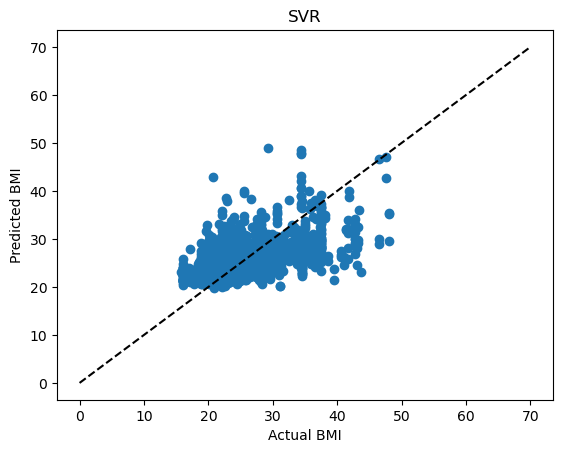

In [42]:
# plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.plot([0, 70], [0, 70], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('SVR')
plt.show()

In [34]:
# SRV
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# show the 3 metrics in the table format using dataframe
pd.DataFrame({
  'MSE': [mse],
  'MAE': [mae],
})

,MSE,MAE
0,17.350732,3.062524


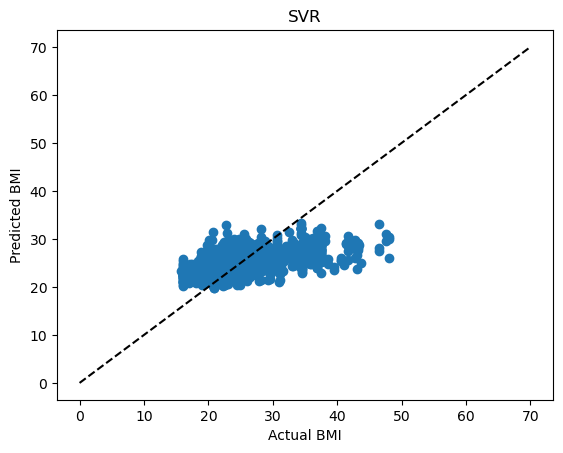

In [35]:
# plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.plot([0, 70], [0, 70], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('SVR')
plt.show()

In [36]:
# Gradient Boosting
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# show the 3 metrics in the table format using dataframe
pd.DataFrame({
  'MSE': [mse],
  'MAE': [mae],
})

,MSE,MAE
0,16.976414,3.05981


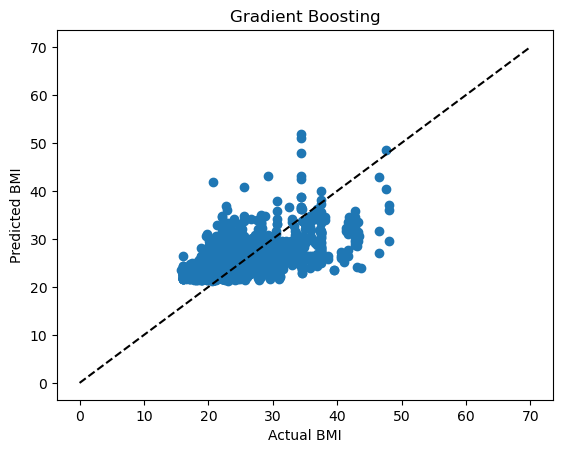

In [37]:
# plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.plot([0, 70], [0, 70], '--k')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Gradient Boosting')
plt.show()